In [59]:
import matplotlib.pyplot as plt

from utils import *
import jax.numpy as np

from optimize import *
from regression import LogisticRegression

import math

# Plotting code

Use the below function to show your line plots.

`all_data` is expected to be a list of experiments, each experiment containing:
1. "steps": an array consisting of the number of data items accessed at each step.
2. "train_loss": the train loss at each step.
3. "label": a label for the experiment

In [60]:
def plot_superimposed_line_series(all_data, classification_problem):
    for series in all_data:
        plt.plot(series['steps'], series['train_loss'], label = series['label'])   
    #
    plt.ylim(0, 1.5)
    plt.xlabel('Number of data items accessed')
    plt.ylabel('NLL')
    plt.title('Performance as a function of data access for '+classification_problem)
    plt.legend()
#

In [61]:
def gather_data(X_train, Y_train, X_val, Y_val, label_0, label_1):
    train_query = np.logical_or(Y_train==label_0, Y_train==label_1)
    val_query = np.logical_or(Y_val==label_0, Y_val==label_1)

    Y_train_query = Y_train[train_query]
    Y_train_mapped = np.where(Y_train_query == label_0, np.zeros(Y_train_query.shape[0]), np.ones(Y_train_query.shape[0]))

    Y_val_query = Y_val[val_query]
    Y_val_mapped = np.where(Y_val_query == label_0, np.zeros(Y_val_query.shape[0]), np.ones(Y_val_query.shape[0]))

    return X_train[train_query], Y_train_mapped, X_val[val_query], Y_val_mapped
#

In [62]:
dataset = 'cifar10'
X_train_all = np.load('X_'+dataset+'_train.npy')
Y_train_all = np.load('Y_'+dataset+'_train.npy')
X_val_all = np.load('X_'+dataset+'_val.npy')
Y_val_all = np.load('Y_'+dataset+'_val.npy')

cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_to_ind = dict([(cifar10_labels[i], i) for i in range(len(cifar10_labels))])

# The Superman split: birds vs. airplanes

In [63]:
# Let's consider the Superman split: birds vs. airplanes
X_train, Y_train, X_val, Y_val = gather_data(X_train_all, Y_train_all, X_val_all, Y_val_all, label_to_ind['bird'], label_to_ind['airplane'])

N = X_train.shape[0]
D = X_train.shape[1]

# total number of data items to access: 2^15
total_data_items = 2**15


# for GD and Newton's method, we require the training data size
T_batch = math.ceil(total_data_items / N)

# for SGD and minibatch methods
T_1 = total_data_items
T_8 = total_data_items // 8
T_32 = total_data_items // 32

# fix the seed
seed = 0

# run optimization below, with step sizes set to (L = Lipschitz constant):
# * GD: 2/L
# * Newton: 0.5
# * Minibatch & SGD: starting step size is 2/L, ending step size is 1e-2/L

lr = LogisticRegression(X_train, Y_train, X_val, Y_val, beta = 1e-1)

init_prng(seed)



Array([0, 0], dtype=uint32)

Running full batch gradient descent:


Optimizing: 100%|██████████| 6/6 [00:00<00:00, 34.18it/s, Loss=0.6479, Step size=0.0111, Update mag=0.0257]


Optimization completed. Final loss: 0.6479
Validation accuracy: 0.2397


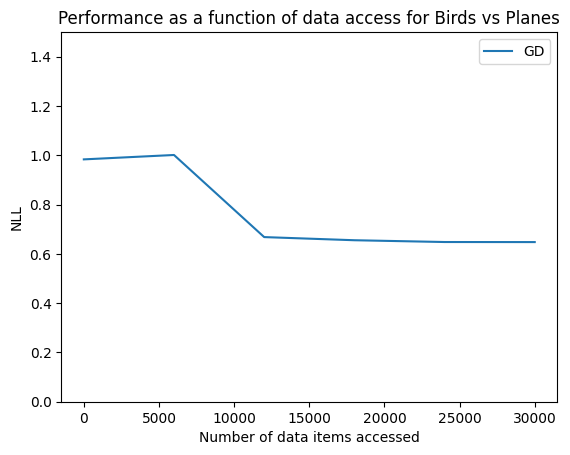

In [64]:
# Running GD with constant step size
print(f"Running full batch gradient descent:")
w0 = lr.initialization()
data_sampler = full_batch_sample()
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
T = T_batch
step_size = constant_step_size(20_000.0 / lr.lipschitz_constant()) # can replace 2 with 15000 to get it to converge
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(N * np.arange(0, T))

experiment1 = {
    "steps": steps,
    "train_loss": losses,
    "label": "GD"
}

all_data = [experiment1]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Birds vs Planes")


Running Newton: 


Optimizing: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s, Loss=0.4558, Step size=0.8330, Update mag=0.0003]

Optimization completed. Final loss: 0.4558
Validation accuracy: 0.2630


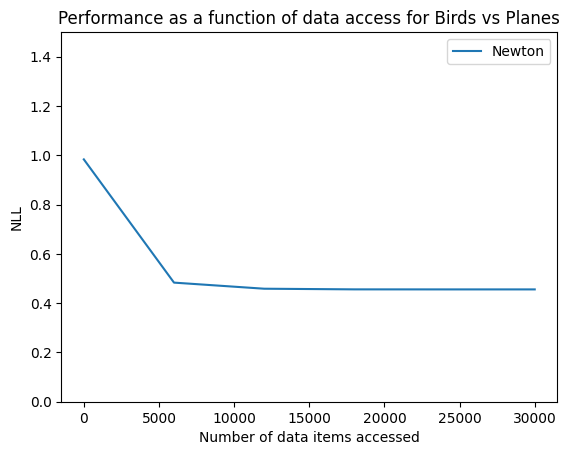

In [65]:
# Running Newton with constant step size
print(f"Running Newton: ")
w0 = lr.initialization()
data_sampler = full_batch_sample()
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_newton(w, data_samples)[1]
T = T_batch
step_size = constant_step_size(1_500_000 / lr.lipschitz_constant()) # can replace 2 with 15000 to get it to converge
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(N * np.arange(0, T))

experiment2 = {
    "steps": steps,
    "train_loss": losses,
    "label": "Newton"
}
all_data = [experiment2]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Birds vs Planes")


Running Minibatch 32: 


Optimizing: 100%|██████████| 1024/1024 [00:11<00:00, 89.94it/s, Loss=0.6151, Step size=0.0011, Update mag=0.0001]


Optimization completed. Final loss: 0.6151
Validation accuracy: 0.2480


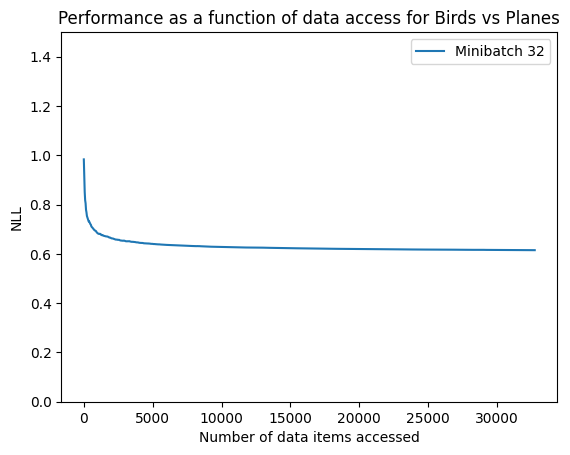

In [66]:
# Running Minibatch 32 with diminishing step size
print(f"Running Minibatch 32: ")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 32)
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
T = T_32
lip = lr.lipschitz_constant() 
step_size = diminishing_step_size(40000 / lip, 2000 / lip, T) 
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(32 * np.arange(0, T))


experiment3 = {
    "steps": steps,
    "train_loss": losses,
    "label": "Minibatch 32"
}
all_data = [experiment3]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Birds vs Planes")

Running Minibatch 8


Optimizing: 100%|██████████| 4096/4096 [00:43<00:00, 94.03it/s, Loss=0.5772, Step size=0.0003, Update mag=0.0002]


Optimization completed. Final loss: 0.5772
Validation accuracy: 0.2552


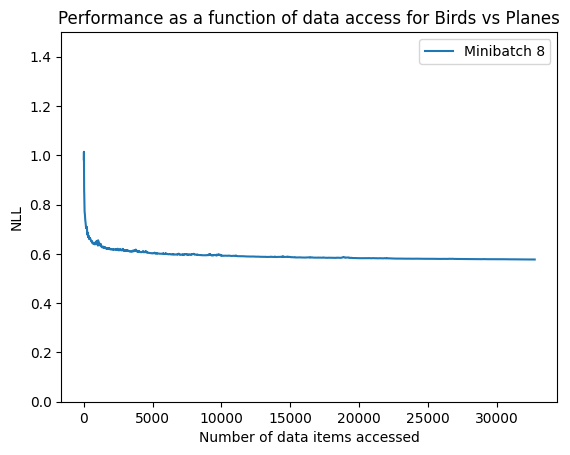

In [67]:
# Running Minibatch 8 with diminishing step size
print(f"Running Minibatch 8")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 8)
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
T = T_8
lip = lr.lipschitz_constant() 
step_size = diminishing_step_size(10000 / lip, 500 / lip, T) 
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(8 * np.arange(0, T))

experiment4 = {
    "steps": steps,
    "train_loss": losses,
    "label": "Minibatch 8"
}
all_data = [experiment4]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Birds vs Planes")

Running SGD


Optimizing: 100%|██████████| 32768/32768 [05:33<00:00, 98.27it/s, Loss=0.5761, Step size=0.0000, Update mag=0.0000] 


Optimization completed. Final loss: 0.5761
Validation accuracy: 0.2565


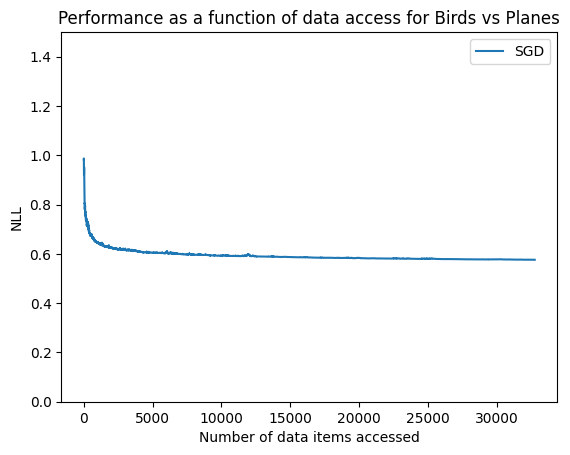

In [68]:
# Running SGD with diminishing step size
print("Running SGD")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 1)
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
T = T_1
lip = lr.lipschitz_constant() 
step_size = diminishing_step_size(100 / lip, 10 / lip, T) 
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(1 * np.arange(0, T))

experiment5 = {
    "steps": steps,
    "train_loss": losses,
    "label": "SGD"
}

all_data = [experiment5]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Birds vs Planes")

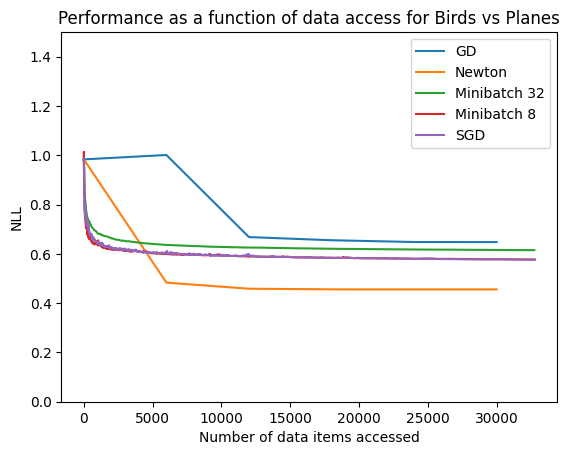

In [69]:
# Showing aggregate plot for Birds vs Planes
all_data = [experiment1, experiment2, experiment3, experiment4, experiment5]
plot_superimposed_line_series(all_data, "Birds vs Planes")


### Discussion

# 
| Experiment Name | Validation Acc |
|-----------------|----------------|
| Full Batch GD   | 0.2397         |
| Newton's Method | 0.2630         |
| Minibatch 32    | 0.2480         |
| Minibatch 8     | 0.2552         |
| SGD             | 0.2565         |

# 


# Deer vs. horses

In [70]:
# Now we will consider deers vs. horses
X_train, Y_train, X_val, Y_val = gather_data(X_train_all, Y_train_all, X_val_all, Y_val_all, label_to_ind['deer'], label_to_ind['horse'])

N = X_train.shape[0]
D = X_train.shape[1]

# total number of data items to access: 2^15
total_data_items = 2**15

# for GD and Newton's method, we require the training data size
T_batch = math.ceil(total_data_items / N)

# for SGD and minibatch methods
T_1 = total_data_items
T_8 = total_data_items // 8
T_32 = total_data_items // 32

# fix the seed
seed = 0

# run optimization below, with step sizes set to (L = Lipschitz constant):
# * GD: 2/L
# * Newton: .5
# * Minibatch & SGD: starting step size is 2/L, ending step size is 1e-2/L

lr = LogisticRegression(X_train, Y_train, X_val, Y_val, beta = 1e-1)

init_prng(seed)

Array([0, 0], dtype=uint32)

Running full batch gradient descent:


Optimizing: 100%|██████████| 6/6 [00:00<00:00, 36.92it/s, Loss=0.8073, Step size=0.0154, Update mag=0.0498]


Optimization completed. Final loss: 0.8073
Validation accuracy: 0.1917


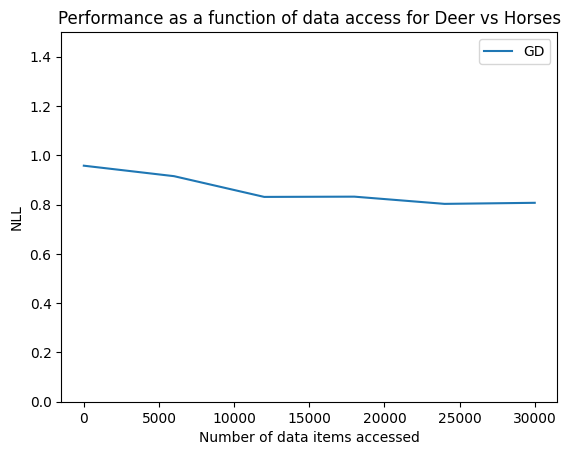

In [71]:
# Running GD with constant step size
print(f"Running full batch gradient descent:")
w0 = lr.initialization()
data_sampler = full_batch_sample()
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
T = T_batch
step_size = constant_step_size(15_000.0 / lr.lipschitz_constant()) # can replace 2 with 15000 to get it to converge
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(N * np.arange(0, T))

experiment1 = {
    "steps": steps,
    "train_loss": losses,
    "label": "GD"
}
all_data = [experiment1]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Deer vs Horses")

Running Newton: 


Optimizing: 100%|██████████| 6/6 [00:04<00:00,  1.31it/s, Loss=0.5332, Step size=1.0297, Update mag=0.0000]

Optimization completed. Final loss: 0.5332
Validation accuracy: 0.2358


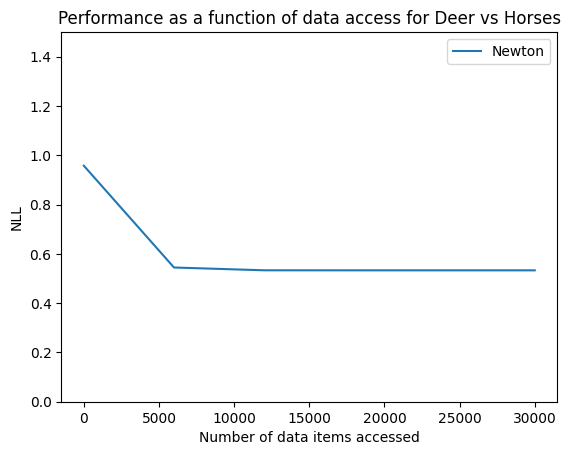

In [72]:
# Running Newton with constant step size
print(f"Running Newton: ")
w0 = lr.initialization()
data_sampler = full_batch_sample()
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_newton(w, data_samples)[1]
T = T_batch
step_size = constant_step_size(1_000_000 / lr.lipschitz_constant()) # can replace 2 with 15000 to get it to converge
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(N * np.arange(0, T))

experiment2 = {
    "steps": steps,
    "train_loss": losses,
    "label": "Newton"
}
all_data = [experiment2]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Deer vs Horses")

Running Minibatch 32: 


Optimizing: 100%|██████████| 1024/1024 [00:10<00:00, 95.79it/s, Loss=0.7164, Step size=0.0021, Update mag=0.0002]


Optimization completed. Final loss: 0.7164
Validation accuracy: 0.2137


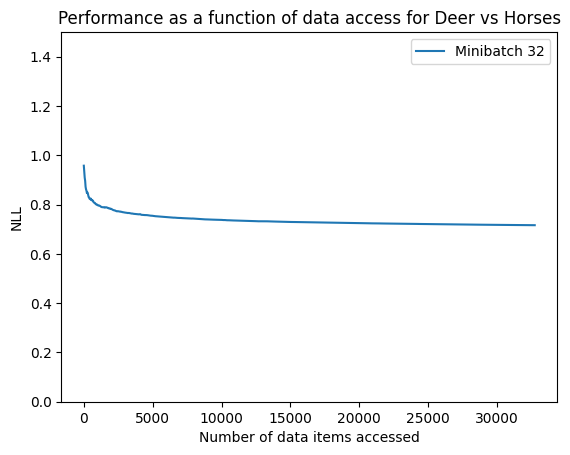

In [73]:
# Running minibatch 32 with diminishing step size
print(f"Running Minibatch 32: ")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 32)
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
T = T_32
lip = lr.lipschitz_constant() 
step_size = diminishing_step_size(40000 / lip, 2000 / lip, T) 
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(32 * np.arange(0, T))


experiment3 = {
    "steps": steps,
    "train_loss": losses,
    "label": "Minibatch 32"
}
all_data = [experiment3]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Deer vs Horses")

Running Minibatch 8


Optimizing: 100%|██████████| 4096/4096 [00:41<00:00, 98.15it/s, Loss=0.6510, Step size=0.0005, Update mag=0.0006] 


Optimization completed. Final loss: 0.6510
Validation accuracy: 0.2308


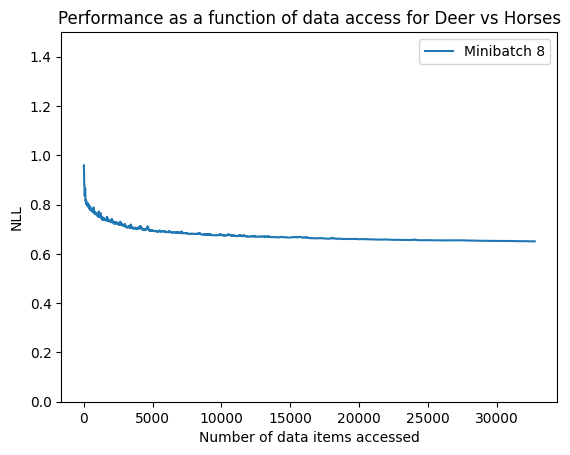

In [74]:
# Running Minibatch 8 with diminishing step size
print(f"Running Minibatch 8")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 8)
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
T = T_8
lip = lr.lipschitz_constant() 
step_size = diminishing_step_size(10000 / lip, 500 / lip, T) 
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(8 * np.arange(0, T))

experiment4 = {
    "steps": steps,
    "train_loss": losses,
    "label": "Minibatch 8"
}
all_data = [experiment4]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Deer vs Horses")

Running SGD


Optimizing: 100%|██████████| 32768/32768 [05:30<00:00, 99.08it/s, Loss=0.6493, Step size=0.0000, Update mag=0.0004] 


Optimization completed. Final loss: 0.6493
Validation accuracy: 0.2293


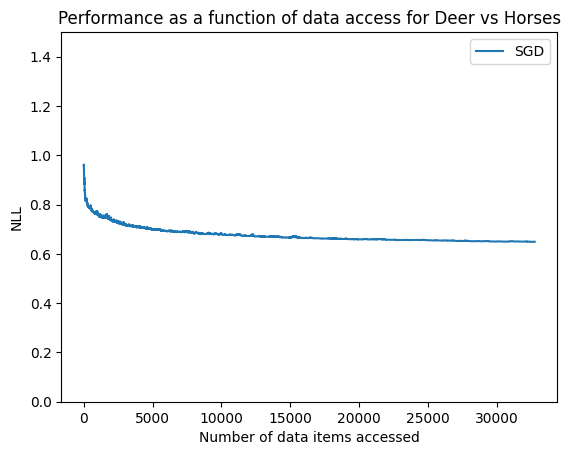

In [75]:
# Running SGD with diminishing step size
print("Running SGD")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 1)
loss_func = lr.train_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
T = T_1
lip = lr.lipschitz_constant() 
step_size = diminishing_step_size(100 / lip, 10 / lip, T) 
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(1 * np.arange(0, T))

experiment5 = {
    "steps": steps,
    "train_loss": losses,
    "label": "SGD"
}
all_data = [experiment5]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Deer vs Horses")



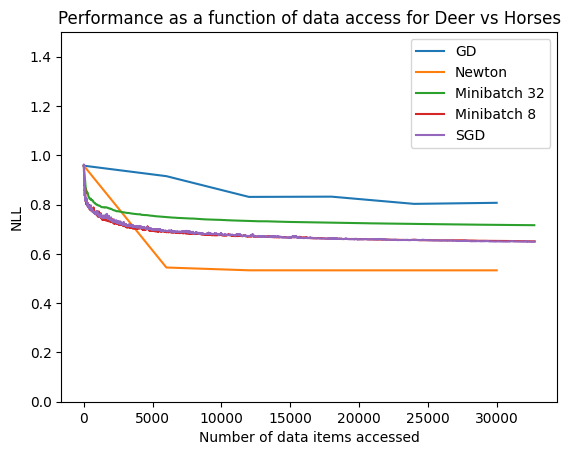

In [76]:
all_data = [experiment1, experiment2, experiment3, experiment4, experiment5]
plot_superimposed_line_series(all_data, "Deer vs Horses")

### Discussion

| Experiment Name | Validation Acc |
|-----------------|----------------|
| Full Batch GD   | 0.1917         |
| Newton's Method | 0.2358         |
| Minibatch 32    | 0.2137         |
| Minibatch 8     | 0.2308         |
| SGD             | 0.2565         |